# USG grants crawl
## Co-Occurance frequency analysis, within-agency

### Previously

In the previous chapter we looked at how often a selected set of open-science infrastructure related terms from [Lee & Chung (2022)](https://doi.org/10.47989/irpaper949) showed up in [grants.gov](https://www.grants.gov/web/grants) grant descriptions, and which agencies' grants they were showing up in.  

For the purposes of our investigation though, we might be curious how frequently certian words are occuring together, _within a specific agency_.  In this way wwe 

### Loading the database once more

Let's begin by loading up the database provided by the website, which is stored in an xml format.

In [1]:
from bs4 import BeautifulSoup
import xmltodict
import sys
import os
import pandas as pd
import glob

# if the cleaned data already exists
if os.path.isfile('allGrantsData.csv'):
    # remember, we are using the bar instead of comma
    grantsDF=pd.read_csv('allGrantsData.csv',sep='|')
    print('Cleaned CSV loaded')
    
    # Use wildcard to find anything that matches the requirement, and use the latest one
elif os.path.isfile(glob.glob(os.path.join('inputData','GrantsDBExtract*.xml'))[-1]):
    pathToXML=glob.glob(os.path.join('inputData','GrantsDBExtract*.xml'))[-1]
    # open and parse file
    with open(pathToXML, 'r') as f:
        govGrantData_raw = f.read()
    # convert xml to dictionary
    with open(pathToXML) as xml_file:
        govGrantData_dictionary = xmltodict.parse(xml_file.read())
        
    # convert to pandas dataframe
    grantsDF=pd.DataFrame.from_records(govGrantData_dictionary['Grants']['OpportunitySynopsisDetail_1_0'], columns=['OpportunityID', 'OpportunityTitle','OpportunityNumber','AgencyCode', 'AgencyName', 'AwardCeiling', 'AwardFloor', 'EstimatedTotalProgramFunding', 'ExpectedNumberOfAwards', 'Description'])
    # proactively replace nans for agency name with other
    # replace the nans
    grantsDF=grantsDF.fillna(0)
    # free up memory
    del govGrantData_dictionary
    
    # now do a bit of cleaning
    grantsDF[['AwardCeiling','AwardFloor','EstimatedTotalProgramFunding','ExpectedNumberOfAwards']]=grantsDF[['AwardCeiling','AwardFloor','EstimatedTotalProgramFunding','ExpectedNumberOfAwards']].astype(np.int64)
    # ideally, the names would all be formatted the same and reliable, allowing us to just index into a pandas column. 
    # however, they're not, so we have to use this approach, and attempt to replace unreliable ones.

    # find the list elements where the agency full name was not available (i.e. worst case), and thus set to NAN (which was then replaced with 0)
    grantsDF['AgencyName'].loc[grantsDF['AgencyName'].eq(0)]='Other'
    # this will serve as a backstop in the event no information was provided

    # in the event no agency code is provided (and thus set to 0) use the capital letters of the agency name
    grantsDF['AgencyCode'].loc[grantsDF['AgencyCode'].eq(0)]=grantsDF['AgencyName'].loc[grantsDF['AgencyCode'].eq(0)].map(lambda x: ''.join([char for char in x if char.isupper()]))

    # however, we don't want to have surreptitiously created the 'O' agency, so set 'O' to other, instead of the abbreviation
    grantsDF['AgencyCode'].loc[grantsDF['AgencyCode'].eq('O')]='Other'

    # also remove everything after the first hyphen.  We dont need to go that far down for this in the hirearchy
    grantsDF['AgencyCode']=grantsDF['AgencyCode'].map(lambda x: x.split('-',1)[0])
    print('XML file loaded, converted to dataframe, and partially cleaned')
else:
# FUTURE NOTE: it may be possible to do a check for a local file meeting the relevant criterion and conditionally 
# download from https://www.grants.gov/extract/ (and extract compressed file) in the event a local target isn't found.
# For the moment though...
    pass

Cleaned CSV loaded


### Keywords and terms

Although we aren't going to inspect the keywords and agencies on their own this time, we still need to collect them.  Once we have loaded them, we can determine which words are occuring in which grants, and which agencies those grants are associated with.  The resulting information can be placed in a dictionary, where the relevant information can be accessed by using the [tuple](https://www.w3schools.com/python/python_tuples.asp) corresponding to the desired agency and keyword (e.g. ('agency','keyword')

In [2]:
import json
import seaborn as sns
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

#HERE'S THE CHANGE FROM THE PREVOUS NOTEBOOK
# open the keywords csv file
inputKeywords=pd.read_csv('OSterms_LeeChung2022.csv')
print(inputKeywords)

# split it into a list.  Each term is kept on a separate line
keywords=inputKeywords['terms'].tolist()

grantFindsOut={}

# iterate through the keywords
for iKeywords in keywords:
    # create a blank list to store the IDs of the grants with the keyword in the description
    grantsFound=[]
    compiledSearch=re.compile('\\b'+iKeywords.lower()+'\\b')
    for iRows,iListing in grantsDF.iterrows():
        # maybe it doesn't have a description field
        try:
            # case insensitive find for the keyword
            if bool(compiledSearch.search(iListing['Description'].lower().replace('-',''))):
                #append the ID if found
                grantsFound.append(iListing['OpportunityID'])
        except:
            # do nothing, if there's no description field, then the word can't be found
            pass
            
    # store the found entries in the output dictionary.  Use the keyword as the key (with spaces replaced with underscores),
    # and the value being the list of grant IDs
    grantFindsOut[iKeywords.replace(' ','_')]=grantsFound
    
#seems that the data can be unreliable, particualrly when we implement the grant funding estimate that comes up shortly
sanityGrantThresh=2000
    
#do the same but for the grant values
grantValVec=[[] for iGrant in range(grantsDF.shape[0]) ]
for iIndex,iListing in grantsDF.iterrows():
        # place the current estimate info in a variable
        currEstimate=np.int64(iListing['EstimatedTotalProgramFunding']) 
        # if it's not == 0, set it as the value
        if not currEstimate == 0: 
            grantValVec[iIndex]=currEstimate
        # otherwise use the ceiling and floor
        # NOTE: in the event that the ceiling and floor won't provided, they will have been NANs in the initial DataFrame
        # this was then replaced with 0
        # the mean of 0 * 1 = 0, so the following is mathematically fine
        else:
            # take the mean and use that times the number of potential awards
            # if the number of expected awards is 0 or too large, treat it as 1
            if iListing['ExpectedNumberOfAwards'] == 0 or np.int64(iListing['ExpectedNumberOfAwards']) >= sanityGrantThresh :
                expectedAwards=1
                #otherwise use the information provided
            else: 
                expectedAwards=np.int64(iListing['ExpectedNumberOfAwards'])
                
            grantValVec[iIndex]=np.mean([np.int64(iListing['AwardCeiling']),np.int64(iListing['AwardFloor'])])*expectedAwards

#grantAgencies=getGrantAgencies(govGrantData_dictionary['Grants']['OpportunitySynopsisDetail_1_0'])
#grantIDs=getGrantIDs(govGrantData_dictionary['Grants']['OpportunitySynopsisDetail_1_0'])
grantAgenciesUnique, counts_elements = np.unique(list(grantsDF['AgencyCode'].values), return_counts=True)
#create dictionary holder
dataHolder={}
for iKeywords in keywords:
    currentGrants=grantFindsOut[iKeywords.replace(' ','_')]
    for iCurrentGrants in currentGrants:
        # find out what it's index is
        # or grantsDF.index[grantsDF['OpportunityID'].eq(iCurrentGrants)]
        currentGrantIndex=list(grantsDF['OpportunityID'].values).index(iCurrentGrants)
        #find out what agency that is
        currentAgency=grantsDF['AgencyCode'].iloc[currentGrantIndex]
        #place it in the dataframe
        matrix_agencyIndex=list(grantAgenciesUnique).index(currentAgency)
        #(row, column)
        #grantIDsDF.loc[currentAgency,iKeywords]=grantIDsDF.loc[iKeywords,currentAgency].append(iCurrentGrants)
        tupleKey=tuple([currentAgency,iKeywords])
        #if it's not there, make it a blank
        if not tupleKey in list(dataHolder.keys()):
            dataHolder[tupleKey]=[]
            
        dataHolder[tupleKey].append(iCurrentGrants)

# create a count matrix
countMatrix=np.zeros([len(keywords),len(grantAgenciesUnique)])
for matrix_keywordIndex, iKeywords in enumerate(keywords):
    for matrix_agencyIndex, iAgency in enumerate(grantAgenciesUnique):
        tupleKey=tuple([iAgency,iKeywords])
        #try and index into it
        try:
            currVal=len(dataHolder[tupleKey])
        except:
        #if it's not there, then there aren't any grants in that cell
            currVal=0
        countMatrix[matrix_keywordIndex,matrix_agencyIndex]=currVal

                                       categories                    terms
0        pre-registrations and registered reports       replication crisis
1        pre-registrations and registered reports              methodology
2        pre-registrations and registered reports          preregistration
3        pre-registrations and registered reports              replication
4        pre-registrations and registered reports       registered reports
5                                       preprints                preprints
6                                       preprints          social sciences
7                                 reproducibility          reproducibility
8                                 reproducibility             transparency
9                                 reproducibility            replicability
10                                reproducibility                 COVID-19
11                                reproducibility                   ethics
12                       

### A small wait

Because the previous analysis isn't coded particularly efficient, it can take a moment to complete.  Part of this has to do with the inefficiency required to index back in to the database, as well as the inefficient storage method for the information we are getting (i.e. appending to lists in a large dictionary)

In any case, once we have the relevant data structure we can look at which agencies are using which terms, and also receive an ouput of the [grants.gov](https://www.grants.gov/web/grants) IDs associated with those grants

In [14]:
# chat-davinci-002 prompt
# an iteractive jupyer notebook widget that returns two subplot windows.  The input is a numerical matrix.  The interface features two dropdown menus that allow you to select a row (i) and column (j) from the matrix.  On the left side of the subplot outputs, a matrix heatmap plotting the numerical data.  On the right side of the subplot outputs, a blank plot that is used to display text indicating the value found in the specific matrix (i,j) entry selected in the dropdown menus.

import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd
import seaborn as sns
from IPython.display import clear_output
from matplotlib.colors import LogNorm
import copy

def plotCoOccurance_Matrix(coOccuranceDictionary,inputAxis,axisItemLabels):
    # ok, lets create a matrix that holds co-occurance data
    # let's start by making a blank matrix to hold the data
    connectivityMatrix=np.zeros((len(axisItemLabels),len(axisItemLabels)), dtype=np.int32())
    # also make a list to hold the rows from this
    dfRowContentAll=[]
    # should be symmetric so x and y doesn't really matter
    # iterate across both axes
    for iIndexX, iKeywordsX in enumerate(axisItemLabels):
        for iIndexY, iKeywordsY in enumerate(axisItemLabels):
            # get the values for each "node" (e.g. the grant IDs for each keyword)
            IDsX=coOccuranceDictionary[iKeywordsX.replace(' ','_')]
            IDsY=coOccuranceDictionary[iKeywordsY.replace(' ','_')]
            # find the intersection
            intersectionGrants=list(set(IDsX) & set(IDsY))
            # find the size of that intersection
            sharedGrantNum=len(intersectionGrants)
            # set the value in the matrix
            connectivityMatrix[iIndexX,iIndexY]=sharedGrantNum
            
    # mask out the diagonal so it doesn't overwhelm the plot
    diagonalMask=np.eye(len(axisItemLabels),dtype=bool)
    # copy the matrix so it can be modified 
    plotMatrix=copy.deepcopy(connectivityMatrix)
    # set the diagonal to zero
    plotMatrix[diagonalMask]=np.zeros(len(axisItemLabels))

    sns.heatmap(data=plotMatrix,ax=inputAxis, yticklabels=axisItemLabels,xticklabels=axisItemLabels,cbar_kws={'label': 'Grant Count'})
    
    # return the plot matrix, if necessary
    return plotMatrix


def filterDictionary(inputDictionary, subsetList):
    '''
    code-davinci-002 prompt:
    A python function which iterates through the key-value pairs of a dictionary, the values
    in which are all lists, and for each key-value pair, subsets the filters the list elements
    to only include those list items which are included in a function input variable named
    subsetList, which is a list.  The function inputs are the dictionary to be filtered, and
    the input list to do the filtering.  The output of the function is the filtered dictionary.
    '''
    outputDictionary = {}
    for key, value in inputDictionary.items():
        outputDictionary[key] = [x for x in value if x in subsetList]
    return outputDictionary

    
def heatmap_plot(matrix, heatmap_ax, row, column):
    """
    Plots the heatmap with a crosshair at the desired location
    """
    # if row is empty, default to column
    if row == '':
        row = column
    # if column is empty, default to row
    if column == '':
        column = row
    # if both are empty, no outline
    if row == '' and column == '':
        row = 0
        column = 0
    # if both are not empty, only highlight the relevant cell
    if row != '' and column != '':
        row = row
        column = column
    # create the heatmap plot
    # NOTE: grantAgenciesUnique and keywords = calls outside of function inputs
    sns.heatmap(matrix, ax=heatmap_ax, norm=LogNorm(), cmap='viridis', cbar=True, xticklabels=list(grantAgenciesUnique) , yticklabels=list(keywords), cbar_kws={'label': 'Grant Count\n(log-scaled)'})
    # create the outline
    heatmap_ax.axvline(x=column+.5, color='red', linewidth=2)
    heatmap_ax.axhline(y=row+.5, color='red', linewidth=2)



# create a function that updates the heatmap
def heatmap_and_coOccurance(countMatrix,rowSelect,columnSelect):
    """
    Plots both the heatmap and the textbox of grants in a 1 by 2 subplot
    """
    fig, ax = plt.subplots(2, 1, figsize=(10, 20))

    # plot the heatmap
    heatmap_plot(countMatrix, heatmap_ax=plt.gcf().get_axes()[0], row=rowSelect, column=columnSelect)
    keyTuple=tuple([col_menu.value,row_menu.value])
    
    # get the list of grants specific to this agency; 
    # NOTE: grantAgenciesUnique and grantsDF= calls outside of function inputs
    currentAgencyGrants=grantsDF['OpportunityID'].loc[grantsDF['AgencyCode'].eq(grantAgenciesUnique[columnSelect])].tolist()
    # use the filter function
    # NOTE: grantFindsOut = call outside of function inputs
    currentGrantsSubsetDictionary=filterDictionary(grantFindsOut, currentAgencyGrants)
    # NOTE: keywords = call outside of function inputs
    plotCoOccurance_Matrix(currentGrantsSubsetDictionary, inputAxis=plt.gcf().get_axes()[1], axisItemLabels=keywords)
    
    # change title
    plt.gcf().get_axes()[1].set_title('Term co-occurrences\nfor ' + grantAgenciesUnique[columnSelect])
    
    # display warning if relevant
    if not countMatrix[rowSelect,columnSelect] > 0:
        plt.text(0.5, 0.5, 'No grants for\n\n ' + keywords[rowSelect] + ' & ' + grantAgenciesUnique[columnSelect], horizontalalignment='center', verticalalignment='center', transform=plt.gcf().get_axes()[1].transAxes,  fontsize=30)

def update_plots(rowSelectName,columnSelectName):
    """
    Performs the updating
    """
    # NOTE: grantAgenciesUnique and keywords = calls outside of function inputs
    rowIndex=keywords.index(rowSelectName)
    colIndex=list(grantAgenciesUnique).index(columnSelectName)
    
    heatmap_and_coOccurance(countMatrix,rowIndex,colIndex)
    
    
# link the dropdown menus to the update functions
#row_menu.observe(update_heatmap, names='value')
#col_menu.observe(update_heatmap, names='value')
# display the widgets
#display(row_menu)
#display(col_menu)

# update the heatmap
#update_heatmap(None)
# create a dropdown menu for the rows
row_menu = widgets.Dropdown(
    options=keywords,
    #value=,
    description='Row:',
    disabled=False,
)
# create a dropdown menu for the columns
col_menu = widgets.Dropdown(
    options=grantAgenciesUnique,
    #value='',
    description='Column:',
    disabled=False,
    )


%matplotlib inline
from ipywidgets import interact
#establishes interactivity
interact(update_plots,rowSelectName=row_menu,columnSelectName=col_menu)

interactive(children=(Dropdown(description='Row:', options=('replication crisis', 'methodology', 'preregistrat…

<function __main__.update_plots(rowSelectName, columnSelectName)>

### Interacting with the plot 

The widget should allow you to select which terms to work with.  For the moment (i.e. early stages of this notebook) the interface is relatively rudamentary but the heatmap plot should feature a crosshair indicating which agency and term you are looking at.  The plot beneath that should inclde a list of the grant.gov IDs.  In many cases no grants are found meeting the criteria, and so a large text indicator should appear stating this.  However in the event that grants are found, they should be listed.  Currently the text scaling for this feature is rudamentary, and so if too many are found their font might be extremely small (future [modifications](https://stackoverflow.com/questions/55729075/matplotlib-how-to-autoscale-font-size-so-that-text-fits-some-bounding-box) could adress this).  Additionally, the text elements themselves may be [capable of being hyperlinks](https://matplotlib.org/stable/gallery/misc/hyperlinks_sgskip.html).

Specific to the plot itself, it's clear to see that the inclusion of "research" is throwing off the analysis.  This is likely because of how generic this term is. 


### How similar are agencies usages of terms?

One question we might ask is if agencies are mentioning these terms in different ways--if the patterns of co-occurrence are _different_ for different agencies.  To answer this question we can take the co-occurrence matrix _for each agency_ and compare them to one another (thus resulting in _another_ matrix, this time agency by agency).  The proper tool for this is called the [cosine distance or cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). This measure provides a measure of distance between two collections of equally sized / shaped quantificaitons (in this case the [unrolled](https://numpy.org/doc/stable/reference/generated/numpy.ravel.html) co-occurrence matrix.  Also, because we don't want the total number of grants for a particular agency to impact this analysis, we'll normalize the vectors (this is likely unnecessary due to how cosine distance works).

#### Interpreting the plot

Overall, what the coloration of the plot will indicate is the degree of similarity or difference in the patterns of term co-occurance for open-science related terms.  Implicitly, we might assume that a high degree of similarity would reflect agencies talking about open science topics in the same way, or focusing on the same aspects.  A high degree of difference would indicate using the terms in differing ways, potentially reflecting differing foci, or even different senses of the words being used (e.g. not in a sense related to open science).  Given that we are plotting _distance_ a value of 0 indicates overlap, and thus maximal similarity.  For this same reason, a value of 1 would the most extreme distance, and thus reflect maximal difference.

<AxesSubplot:>

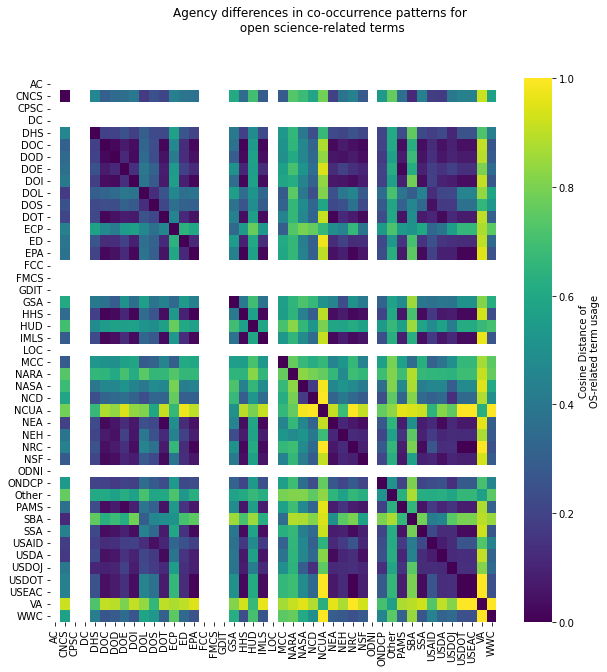

In [29]:
import scipy

normalizeVecs=True

# create a 3d holder for the output, keywords by keywords by agency
coOccurrenceStack=np.zeros([len(keywords),len(keywords),len(grantAgenciesUnique)])
# iterate through each agency and create a co-occurrence matrix.  Then stack these
for iAgencyIndex,iAgencies in enumerate(grantAgenciesUnique):
    # generate a holder for the co-occurrence data
    connectivityMatrix=np.zeros((len(keywords),len(keywords)), dtype=np.int32())
    # get the grant IDs for the current agency
    currentAgencyGrants=grantsDF['OpportunityID'].loc[grantsDF['AgencyCode'].eq(iAgencies)].tolist()
    # generate the relevant subset of the omnibus grant-keyword-agency dictionary
    currentGrantsSubsetDictionary=filterDictionary(grantFindsOut, currentAgencyGrants)
    
    
    # pass it to the loops to check co-occurrence
    # iterate across both axes
    for iIndexX, iKeywordsX in enumerate(keywords):
        for iIndexY, iKeywordsY in enumerate(keywords):
            # get the values for each "node" (e.g. the grant IDs for each keyword)
            IDsX=currentGrantsSubsetDictionary[iKeywordsX.replace(' ','_')]
            IDsY=currentGrantsSubsetDictionary[iKeywordsY.replace(' ','_')]
            # find the intersection
            intersectionGrants=list(set(IDsX) & set(IDsY))
            # find the size of that intersection
            sharedGrantNum=len(intersectionGrants)
            # set the value in the matrix
            connectivityMatrix[iIndexX,iIndexY]=sharedGrantNum
            
    # when done, set it in the holder
    coOccurrenceStack[:,:,iAgencyIndex]=connectivityMatrix

# quick definition of normalize function
def normalizeVector(inputVec):
    # note, these are counts so they are necessarily positive
    # if it's not empty
    if not np.sum(inputVec)==0:
        normalizedVector=np.divide(inputVec,np.sum(inputVec))
    else: 
        # otherwise
        normalizedVector=inputVec
    return normalizedVector

# create a holder for the cosine distance analysis
cosineDists_agency=np.zeros([len(grantAgenciesUnique),len(grantAgenciesUnique)])

#once the co-occurrence stack is complete, perform the cosine analysis
for iIndexX, iAgenciesX in enumerate(grantAgenciesUnique):
    for iIndexY, iAgenciesY in enumerate(grantAgenciesUnique):
        # get the stack slice for each agency
        agencyX_slice=coOccurrenceStack[:,:,iIndexX]
        agencyY_slice=coOccurrenceStack[:,:,iIndexY]
        
        # flatten it into a single vector for each
        agencyX_vec=np.ravel(agencyX_slice)
        agencyY_vec=np.ravel(agencyY_slice)
        
        if (not np.sum(agencyX_vec)==0) and (not np.sum(agencyY_vec)==0):
        
            # if we want to normalize, do that
            if normalizeVecs:
                agencyX_vec=normalizeVector(agencyX_vec)
                agencyY_vec=normalizeVector(agencyY_vec)

            #in either case, perform the cosine analysis
            currentDistance=scipy.spatial.distance.cosine(agencyX_vec,agencyY_vec)
            # set it in the output matrix
        
        
            cosineDists_agency[iIndexX,iIndexY]=currentDistance
        else:
            cosineDists_agency[iIndexX,iIndexY]=np.nan
        
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Agency differences in co-occurrence patterns for\n open science-related terms')
# plot the result
sns.heatmap(data=cosineDists_agency, cmap='viridis', yticklabels=grantAgenciesUnique,xticklabels=grantAgenciesUnique,cbar_kws={'label': 'Cosine Distance of\nOS-related term usage'})